In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import convokit
from convokit import Corpus, download, TriadMotif, Thread
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [4]:
corpus = Corpus(filename="/Users/calebchiam/Documents/datasets/news-filtered-corpus")

In [5]:
corpus.print_summary_stats()

Number of Users: 436784
Number of Utterances: 3182961
Number of Conversations: 208732


In [6]:
threads = corpus.utterance_threads(include_root=False)

In [7]:
print(len(threads))

502399


## Initialize thread objects

In [8]:
thread_objs = dict()
fails = []
for thread_id, thread_utts in threads.items():
    thread_obj = Thread(list(thread_utts.values()))
    if thread_obj.check_integrity(verbose=False):
        thread_objs[thread_id] = thread_obj
        thread_obj.annotate_depth()

In [9]:
print("Broken threads", len(threads) - len(thread_objs))

Broken threads 6124


## Initialize thread hypergraphs

In [10]:
threads = corpus.utterance_threads(include_root=False)
threads_hypergraphs = dict()
for i, (root, thread) in enumerate(threads.items()):
    G = convokit.HyperConvo._make_hypergraph(uts=thread)
    threads_hypergraphs[root] = G

## Some descriptive stats on the top-level comment threads from 1 Oct 2017 - 1 Oct 2018

In [11]:
# Number of threads
len(thread_objs)

496275

## Distribution of number of participants in the threads

In [12]:
from collections import defaultdict
threads_num_users = defaultdict(int)
for thread_id, hg in threads_hypergraphs.items():
    threads_num_users[len(hg.hypernodes)] += 1

In [13]:
sorted(list(threads_num_users.items()))[:30]

[(1, 337217),
 (2, 63175),
 (3, 29811),
 (4, 16947),
 (5, 10768),
 (6, 7541),
 (7, 5471),
 (8, 4092),
 (9, 3326),
 (10, 2674),
 (11, 2218),
 (12, 1815),
 (13, 1462),
 (14, 1245),
 (15, 1067),
 (16, 899),
 (17, 792),
 (18, 694),
 (19, 624),
 (20, 568),
 (21, 518),
 (22, 447),
 (23, 432),
 (24, 360),
 (25, 340),
 (26, 320),
 (27, 291),
 (28, 295),
 (29, 261),
 (30, 212)]

In [14]:
# convokit.display_thread(threads, 'e58r4yf')

In [15]:
from itertools import permutations
def identify_final_motif(hg, userA, userB, userC):
    # We use the identities of user A, B, C (i.e. top-level-commenter, first replier, first third-party replier)
    # to simplify the typically-difficult final motif identification step
    num_edge_dirs = 0
    for user_pair in permutations([userA, userB, userC], 2):
        if len(hg.adj_in[user_pair[0]].get(user_pair[1], [])) > 0:
            num_edge_dirs += 1
    
    # sanity check
    assert 2 <= num_edge_dirs <= 6
    if num_edge_dirs == 6:
        return 'TRIRECIPROCAL_TRIADS'
    elif num_edge_dirs == 5:
        return 'DIRECIPROCAL_2TO3_TRIADS'
    elif num_edge_dirs == 4:
        if len(hg.adj_out[userB].get(userC, [])) == 0 and len(hg.adj_out[userC].get(userB, [])) == 0:
            # B and C do not talk
            return "DIRECIPROCAL_TRIADS"
        elif len(hg.adj_out[userB].get(userC, [])) > 0 and len(hg.adj_out[userC].get(userB, [])) > 0:
            # B and C talk to each other
            return "INCOMING_RECIPROCAL_TRIADS"
        elif len(hg.adj_out[userC].get(userB, [])) > 0 and len(hg.adj_out[userC].get(userA, [])) > 0 and \
                len(hg.adj_in[userC].get(userB, [])) == 0 and len(hg.adj_in[userC].get(userA, [])) == 0:
            # C talks to A and B but gets no responses
            return "OUTGOING_RECIPROCAL_TRIADS"
        elif len(hg.adj_out[userB].get(userC, [])) > 0 and len(hg.adj_out[userB].get(userA, [])) > 0 and \
                len(hg.adj_in[userB].get(userC, [])) == 0 and len(hg.adj_in[userC].get(userA, [])) == 0:
            # B talks to A and C but gets no response
            return "OUTGOING_RECIPROCAL_TRIADS"
        else:
            return "DIRECTED_CYCLE_1TO3_TRIADS"
    elif num_edge_dirs == 3:
        if len(hg.adj_in[userC].get(userA, [])) > 0: # A talks to C
            if len(hg.adj_in[userA].get(userC, [])) > 0: # C talks to A
                return "INCOMING_1TO3_TRIADS"
            else: # C does not talk to A
                return "DIRECTED_CYCLE_TRIADS"
        else: # A does not tak to C
            if len(hg.adj_out[userC].get(userB, [])) > 0: # C talks to B
                return "OUTGOING_3TO1_TRIADS"
            else:
                return "INCOMING_2TO3_TRIADS"
    elif num_edge_dirs == 2:
        # cannot be outgoing by definition, can only be incoming or unidirectional
        if len(hg.adj_in[userA].get(userC, [])) > 0:
            return 'INCOMING_TRIADS'
        else:
            return 'UNIDIRECTIONAL_TRIADS'

        

In [16]:
# thread_objs['e56q3vo'].utterances

In [17]:
broken_threads = []
one_commenter_threads = []
two_commenter_threads = []
three_or_more_threads = []
for thread_id, thread_obj in thread_objs.items():
    hg = threads_hypergraphs[thread_id]
    if not thread_obj.check_integrity(verbose=False):
        broken_threads.append(thread_id)
        continue
    userA, userB, userC = thread_obj.identify_ABC()
    if userB is None:
        one_commenter_threads.append(thread_id)
    elif userC is None:
        density = thread_obj.get_AB_density(userA, userB)
        two_commenter_threads.append((thread_id, 'DYADIC_TRIADS', density, -1, "nil"))
    else:
        final_type = identify_final_motif(hg, thread_obj.get_user(userA), 
                                          thread_obj.get_user(userB), thread_obj.get_user(userC))
#         print(userA, userB, userC)
        density = thread_obj.get_AB_density_beforeC(userA, userB, userC)
        C_depth, target = thread_obj.get_C_entrance(userA, userB, userC) 
        three_or_more_threads.append((thread_id, final_type, density, C_depth, target))
        

In [18]:
print("Total threads", len(threads))
print("threads with one commenter", len(one_commenter_threads))
print("threads with two commenters", len(two_commenter_threads))
print("threads with >=3 commenters", len(three_or_more_threads))
print("threads with broken structure", len(threads) - len(one_commenter_threads) - len(two_commenter_threads) - len(three_or_more_threads))

Total threads 502399
threads with one commenter 334198
threads with two commenters 61757
threads with >=3 commenters 100320
threads with broken structure 6124


Let **C_depth** be defined as the depth of the top-level-comment tree that C's first utterance is located at. The top-level-comment has depth 1, so if C responds to the top-level-comment directly, then C_depth = 2.

Let **density** be the number of utterances directed from A to B or B to A. For non-dyadic threads (i.e. threads with >=3 users), this is the density before C first arrives. (Note: self-replies are not counted.)

Let **C_target** be the speaker of the utterance that C first responds to.

In [19]:
df = pd.DataFrame(data=two_commenter_threads+three_or_more_threads, columns=['thread_id', 'motif_type', 'density', 'C_depth', 'C_target'])

In [20]:
df = df.set_index('thread_id')

In [21]:
df.head()

,motif_type,density,C_depth,C_target
thread_id,,,,
c0850fv,DYADIC_TRIADS,2,-1,nil
c0852q8,DYADIC_TRIADS,2,-1,nil
c0854fo,DYADIC_TRIADS,4,-1,nil
c085eww,DYADIC_TRIADS,2,-1,nil
c085jp6,DYADIC_TRIADS,2,-1,nil


In [22]:
Counter(df['motif_type'])

Counter({'DYADIC_TRIADS': 61757,
         'DIRECIPROCAL_TRIADS': 7311,
         'OUTGOING_3TO1_TRIADS': 13758,
         'UNIDIRECTIONAL_TRIADS': 18019,
         'INCOMING_TRIADS': 35058,
         'INCOMING_2TO3_TRIADS': 11903,
         'INCOMING_1TO3_TRIADS': 7563,
         'INCOMING_RECIPROCAL_TRIADS': 3700,
         'OUTGOING_RECIPROCAL_TRIADS': 665,
         'DIRECTED_CYCLE_1TO3_TRIADS': 846,
         'DIRECTED_CYCLE_TRIADS': 395,
         'DIRECIPROCAL_2TO3_TRIADS': 930,
         'TRIRECIPROCAL_TRIADS': 172})

In [23]:
sorted(list(Counter(df[df['motif_type'] != 'DYADIC_TRIADS']['density']).items()))[:30]

[(1, 119),
 (2, 82014),
 (3, 12645),
 (4, 3237),
 (5, 1174),
 (6, 508),
 (7, 233),
 (8, 157),
 (9, 89),
 (10, 56),
 (11, 23),
 (12, 17),
 (13, 14),
 (14, 11),
 (15, 7),
 (16, 1),
 (17, 1),
 (18, 3),
 (19, 4),
 (20, 1),
 (21, 2),
 (26, 1),
 (29, 1),
 (30, 1),
 (32, 1)]

In [24]:
Counter(df['C_target'])

Counter({'nil': 61757, 'A': 64198, 'B': 36122})

In [25]:
Counter(df['density'])

Counter({2: 127523,
         4: 6326,
         3: 22836,
         15: 26,
         5: 2505,
         6: 1135,
         12: 54,
         11: 80,
         16: 14,
         13: 44,
         10: 142,
         7: 597,
         9: 218,
         8: 358,
         14: 31,
         17: 14,
         31: 1,
         18: 9,
         20: 9,
         27: 1,
         24: 2,
         30: 4,
         19: 10,
         22: 2,
         23: 2,
         39: 1,
         26: 4,
         28: 2,
         41: 1,
         32: 2,
         21: 3,
         49: 1,
         1: 119,
         29: 1})

## C joins vs C does not join at each density k

In [26]:
no_dyadic_df = df[df['motif_type'] != 'DYADIC_TRIADS']

In [27]:
no_dyadic_df.shape

(100320, 4)

In [28]:
dyadic_df = df[df['motif_type'] == 'DYADIC_TRIADS']

In [29]:
C_joins_percent = []
for k in range(2, 11):
    C_join_num = no_dyadic_df[no_dyadic_df['density'] == k].shape[0]
    C_no_join_num_dyadic = dyadic_df[dyadic_df['density'] >= k].shape[0]
    C_no_join_num_others = no_dyadic_df[no_dyadic_df['density'] > k].shape[0]
    C_no_join = C_no_join_num_dyadic + C_no_join_num_others
    C_joins_percent.append(C_join_num / (C_join_num + C_no_join))

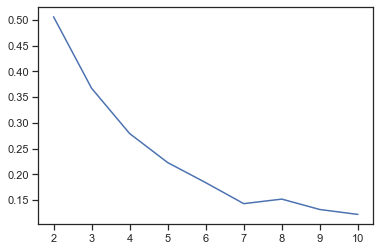

In [30]:
sns.lineplot(x=range(2,11), y=C_joins_percent)

## Which part of the thread does C join?

### Basic counts of C's depth

In [31]:
ctr = Counter(no_dyadic_df['C_depth'])

In [32]:
num_instances = [ctr[x] for x in range(2, 11)]

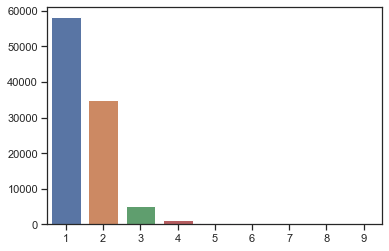

In [33]:
# Num instances against depth of comment C responds to (1 = top-level-comment)
sns.barplot(x=list(range(1,10)), y=num_instances)

### Plotting which part of the thread C (C's depth) joins against density before C's entrance

In [34]:
no_dyadic_df.groupby('density').mean()

,C_depth
density,
1,2.016807
2,2.384142
3,2.889522
4,3.360828
5,3.917376
6,4.507874
7,4.969957
8,5.828025
9,5.988764


In [35]:
y = no_dyadic_df.groupby('density').mean().values[1:10].flatten() # exclude density == 1 (edge cases)

In [36]:
x = range(2, 11)

Text(0.5, 1.0, 'C_depth against density')

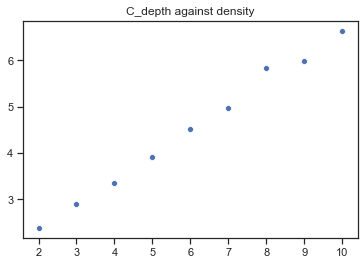

In [37]:
# C's depth against A/B density before C enters
sns.scatterplot(x=x, y=y).set_title('C_depth against density')

Text(0.5, 1.0, '(C_depth - density) against density')

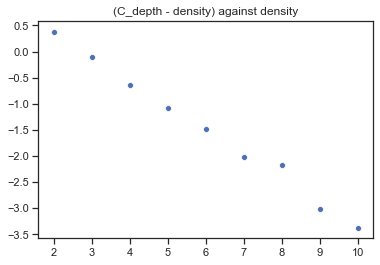

In [38]:
# C's depth against A/B density before C enters
sns.scatterplot(x=x, y=y-x).set_title('(C_depth - density) against density')

### How does C's depth on joining correlate to the final motif?

In [39]:
triad_order = convokit.TriadMotif.get_motif_types()

In [40]:
motif_to_Cdepth = df.groupby('motif_type')['C_depth'].mean().to_dict()

In [41]:
y = [motif_to_Cdepth[motif] for motif in triad_order if motif in motif_to_Cdepth]

In [42]:
triad_order

['NO_EDGE_TRIADS',
 'SINGLE_EDGE_TRIADS',
 'INCOMING_TRIADS',
 'OUTGOING_TRIADS',
 'DYADIC_TRIADS',
 'UNIDIRECTIONAL_TRIADS',
 'INCOMING_2TO3_TRIADS',
 'DIRECTED_CYCLE_TRIADS',
 'INCOMING_1TO3_TRIADS',
 'OUTGOING_3TO1_TRIADS',
 'INCOMING_RECIPROCAL_TRIADS',
 'OUTGOING_RECIPROCAL_TRIADS',
 'DIRECTED_CYCLE_1TO3_TRIADS',
 'DIRECIPROCAL_TRIADS',
 'DIRECIPROCAL_2TO3_TRIADS',
 'TRIRECIPROCAL_TRIADS']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

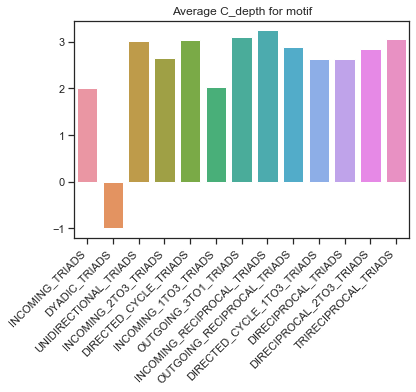

In [43]:
sns.barplot(x=[motif for motif in triad_order if motif in motif_to_Cdepth], y=y)
plt.title('Average C_depth for motif')
plt.xticks(rotation=45, horizontalalignment='right')

In [44]:
motif_to_Cdepth

{'DIRECIPROCAL_2TO3_TRIADS': 2.838709677419355,
 'DIRECIPROCAL_TRIADS': 2.636575023936534,
 'DIRECTED_CYCLE_1TO3_TRIADS': 2.615839243498818,
 'DIRECTED_CYCLE_TRIADS': 3.0354430379746837,
 'DYADIC_TRIADS': -1.0,
 'INCOMING_1TO3_TRIADS': 2.0178500595001982,
 'INCOMING_2TO3_TRIADS': 2.643199193480635,
 'INCOMING_RECIPROCAL_TRIADS': 3.2375675675675675,
 'INCOMING_TRIADS': 2.008557247989047,
 'OUTGOING_3TO1_TRIADS': 3.106992295391772,
 'OUTGOING_RECIPROCAL_TRIADS': 2.887218045112782,
 'TRIRECIPROCAL_TRIADS': 3.052325581395349,
 'UNIDIRECTIONAL_TRIADS': 3.006826127976025}

### C_target against C_depth 

Note that we expect an obvious correlation between the two.

In [45]:
C_target_grouped_by_depth = no_dyadic_df.groupby('C_depth')['C_target'].value_counts(normalize=True).unstack()

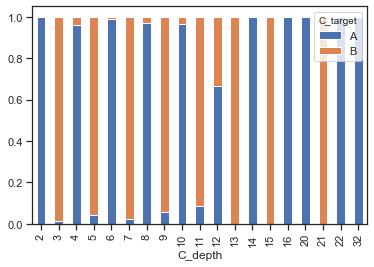

In [46]:
C_target_grouped_by_depth.plot(kind='bar',stacked=True)

### Alternate view: C_depth against C_target

In [47]:
C_depth_grouped_by_target = no_dyadic_df.groupby('C_target')['C_depth'].value_counts(normalize=True).unstack()

In [48]:
C_depth_grouped_by_target.T

C_target,A,B
C_depth,,
2,0.906695,NaN
3,0.006838,0.956647
4,0.076669,0.005426
5,0.000748,0.030148
6,0.006589,0.000111
7,0.000078,0.005232
8,0.001542,0.000083
9,0.000047,0.001384
10,0.000452,0.000028
